In [3]:
# 1010 패턴

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 1010 패턴을 이용해서 데이터를 생성하는 함수
def generate_real():
  return torch.FloatTensor([1,0,1,0])

In [6]:
generate_real()

tensor([1., 0., 1., 0.])

In [7]:
import random

In [8]:
# 데이터 생성
def generate_real():
  real_data = torch.FloatTensor([
   random.uniform(0.8,1.0),
   random.uniform(0.0,0.2),   
   random.uniform(0.8,1.0),
   random.uniform(0.0,0.2)
  ])
  return real_data

generate_real()  

tensor([0.8957, 0.1118, 0.8357, 0.0250])

In [9]:
# 판별기
class Discriminator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.MSELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.SGD(self.parameters(), lr= 1e-2)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)
    
  def train(self, inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:
      print(f"count = {self.count}")      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    

  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )

In [10]:
# 판별기 테스트 - 생성기 만들기전에 제대로 판별하는지 확인
# 노이즈 패턴 만들기
def generate_random(size):
  return torch.rand(size)


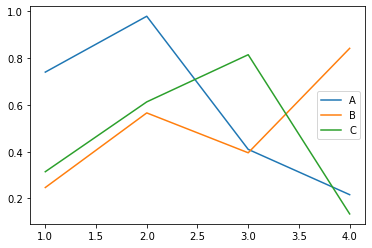

In [11]:
temp = pd.DataFrame({'A': torch.rand(4),
                    'B': torch.rand(4),
                     'C': torch.rand(4)},
                    index=[1, 2, 3, 4])
temp.plot()

In [ ]:
# 1010 패턴데이터는 진짜.... 출력은 1
# 노이즈 패턴 가짜           출력은 0
# 10000번 훈련
D = Discriminator()
for i in range(10000):
  # 실제데이터
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(4), torch.FloatTensor([0.0]))

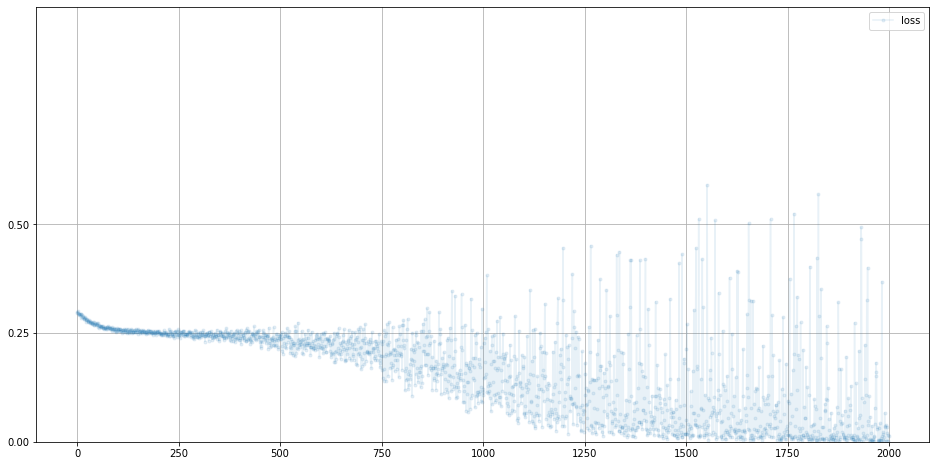

In [13]:
D.plot_progress()

In [14]:
D.forward(generate_real()).item(), D.forward(generate_random(4)).item()

(0.8262766003608704, 0.04812992364168167)

In [15]:
# 생성기
class Generator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.MSELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.SGD(self.parameters(), lr= 1e-2)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)

  def train(self, D,inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 판별기로 전달
    outputs = D.forward(outputs)

    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()      
  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )    

In [16]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.5107, 0.4407, 0.5035, 0.6600], grad_fn=<SigmoidBackward0>)

In [ ]:
D = Discriminator()
G = Generator()
for i in range(10000):
  # 참에대한 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 거짓dp 대한 판별기 훈련
  # 이때 G의 기울기가 계산되면 안된다. detach()이용
  D.train( G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0] ))
  # 생성기 훈련
  G.train(D,torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))


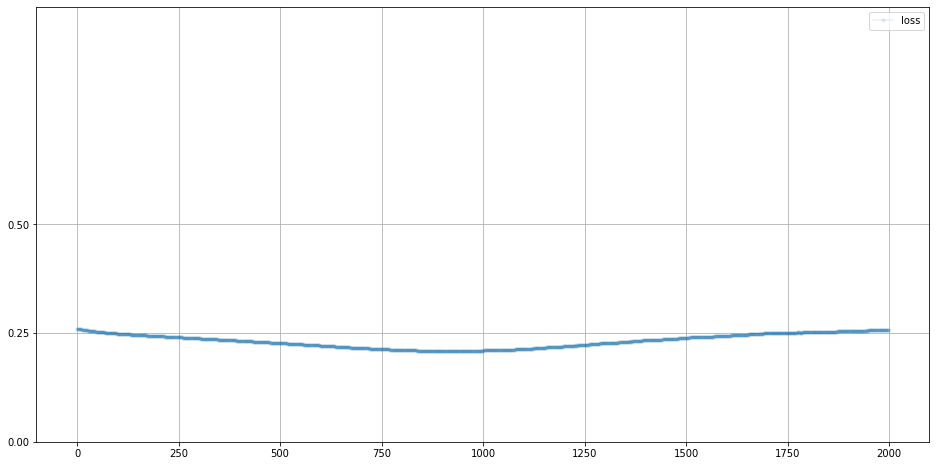

In [18]:
D.plot_progress()

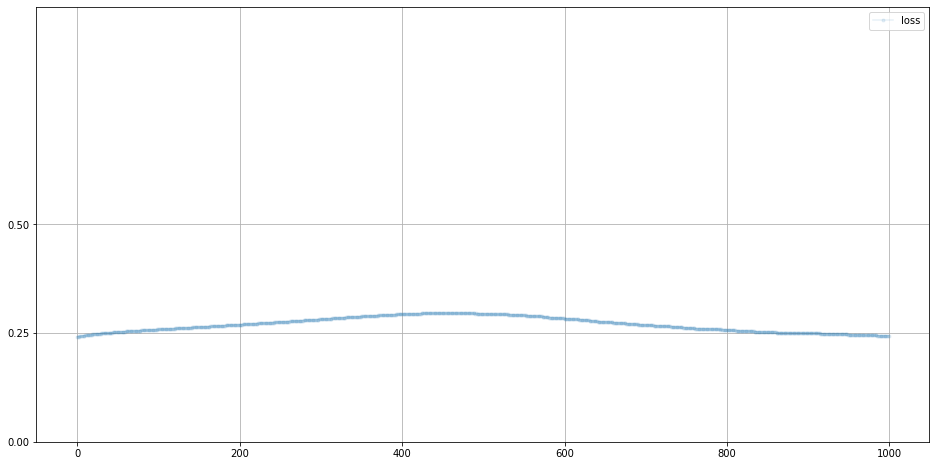

In [19]:
G.plot_progress()

In [20]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9312, 0.0974, 0.9113, 0.0739], grad_fn=<SigmoidBackward0>)

MNIST 판별기

In [24]:
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision import transforms

In [41]:
# 판별기
class Discriminator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(28*28,200),
        nn.Sigmoid(),
        nn.Linear(200,1),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.MSELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.SGD(self.parameters(), lr= 1e-2)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)
    
  def train(self, inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    

  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )

In [25]:
# 생성기
# 판별기가 실제 이미지와 임의의 노이즈간의 구별을 할수 있는지 확인
# 다운로드 받을 경로
root_dir = './mnist_data'
# 변환방법
mnist_transform = transforms.Compose([
  transforms.ToTensor(),  
  transforms.Normalize((0.5,),(1.0))    
])

# 데이터셋 - 실제
train_dataset = MNIST(root_dir,transform= mnist_transform, train=True, download=True)
# 데이터 로드 - 배치단위로 묶음

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [33]:
a,b = next(iter(train_dataset))
a.shape, type(b)

(torch.Size([1, 28, 28]), int)

In [42]:
D = Discriminator()

In [43]:
import torch
from tqdm import tqdm
for image, target in tqdm(train_dataset):
  # 실제 데이터
  image = image.view(1,28*28)  
  D.train(image,torch.FloatTensor([1.0]))
  # 가짜 노이즈 데이터(생성된 데이터)
  D.train(generate_random(28*28),torch.FloatTensor([0.0]))

100%|██████████| 60000/60000 [01:58<00:00, 504.37it/s]


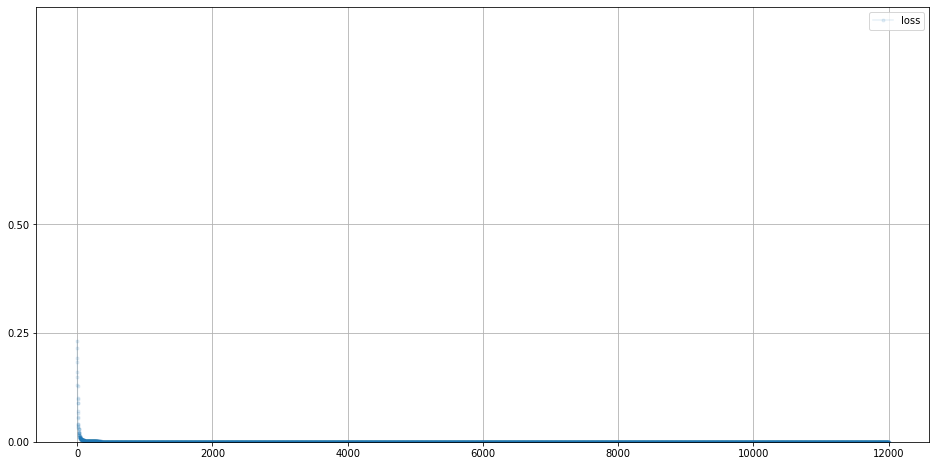

In [44]:
D.plot_progress()

In [45]:
# 임의데이터
val_dataset = MNIST(root_dir,transform= mnist_transform, train=False, download=True)

In [61]:
rnd_ist = random.sample(range(len(val_dataset)),10)

In [62]:
# 판별기 성능 테스트
for i in rnd_ist:
  image, target = val_dataset[i]
  image.shape, target
  image = image.view(1,28*28)
  print(D.forward(image), D.forward(generate_random(28*28)), target)

tensor([[0.9984]], grad_fn=<SigmoidBackward0>) tensor([0.0037], grad_fn=<SigmoidBackward0>) 1
tensor([[0.9958]], grad_fn=<SigmoidBackward0>) tensor([0.0039], grad_fn=<SigmoidBackward0>) 6
tensor([[0.9972]], grad_fn=<SigmoidBackward0>) tensor([0.0036], grad_fn=<SigmoidBackward0>) 0
tensor([[0.9975]], grad_fn=<SigmoidBackward0>) tensor([0.0037], grad_fn=<SigmoidBackward0>) 4
tensor([[0.9975]], grad_fn=<SigmoidBackward0>) tensor([0.0032], grad_fn=<SigmoidBackward0>) 0
tensor([[0.9979]], grad_fn=<SigmoidBackward0>) tensor([0.0035], grad_fn=<SigmoidBackward0>) 1
tensor([[0.9981]], grad_fn=<SigmoidBackward0>) tensor([0.0030], grad_fn=<SigmoidBackward0>) 1
tensor([[0.9980]], grad_fn=<SigmoidBackward0>) tensor([0.0036], grad_fn=<SigmoidBackward0>) 1
tensor([[0.9966]], grad_fn=<SigmoidBackward0>) tensor([0.0034], grad_fn=<SigmoidBackward0>) 6
tensor([[0.9931]], grad_fn=<SigmoidBackward0>) tensor([0.0034], grad_fn=<SigmoidBackward0>) 9


In [63]:
# 생성기 : 훈련데이터의 여러 양상을 다양하게 반영하도록 이미지를 생성 
# 매훈련마다 임의의 상수를 입력(0.5는 안됨)
# 생성기
class Generator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.Sigmoid(),
        nn.Linear(200,28*28),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.MSELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.SGD(self.parameters(), lr= 1e-2)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)

  def train(self, D,inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 판별기로 전달
    outputs = D.forward(outputs)

    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()      
  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )    

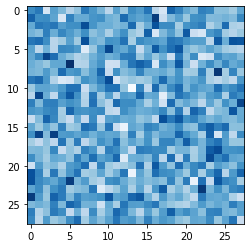

In [79]:
# 생성기 확인
G = Generator()
output = G.forward(generate_random(1))
# 계산 그래프에 속해있어서 분리
img =  output.detach().numpy().reshape(28,28)
plt.imshow(img,interpolation=None,cmap = 'Blues')

In [68]:
# GAN  훈련
D = Discriminator()
G = Generator()

# 판별기 생성기 훈련
import torch
from tqdm import tqdm
for image, target in tqdm(train_dataset):
  # 참에 대한 데이터
  image = image.view(1,28*28)  
  D.train(image,torch.FloatTensor([1.0]))
  # 가짜 데이터에 대한 판별기 훈련
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0])  ) 

  # 생성기
  G.train(D,generate_random(1), torch.FloatTensor([1.0]))


100%|██████████| 60000/60000 [03:26<00:00, 290.59it/s]


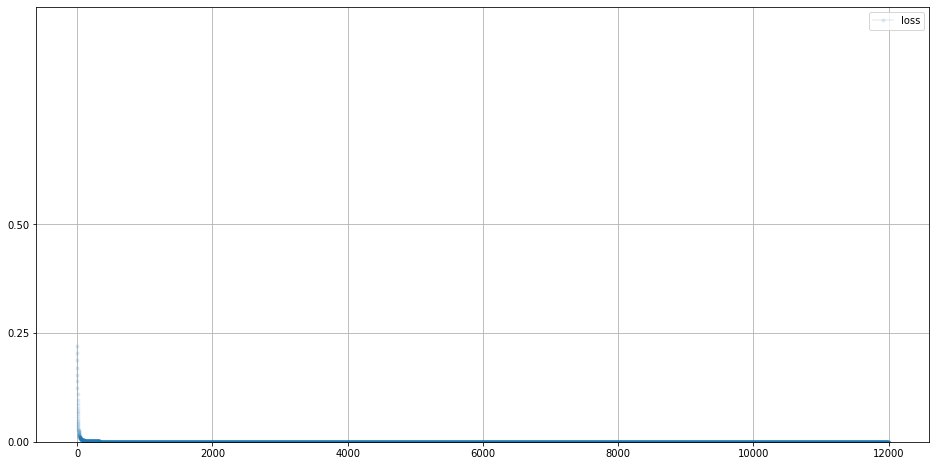

In [69]:
D.plot_progress()

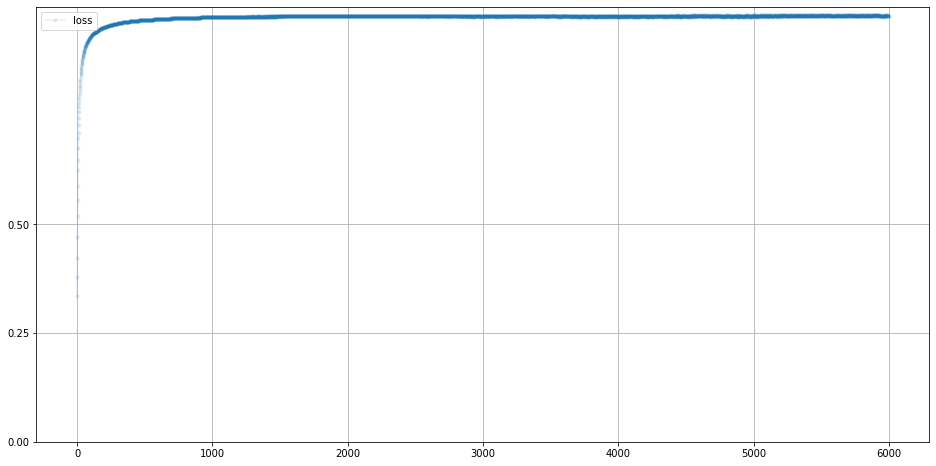

In [70]:
G.plot_progress()

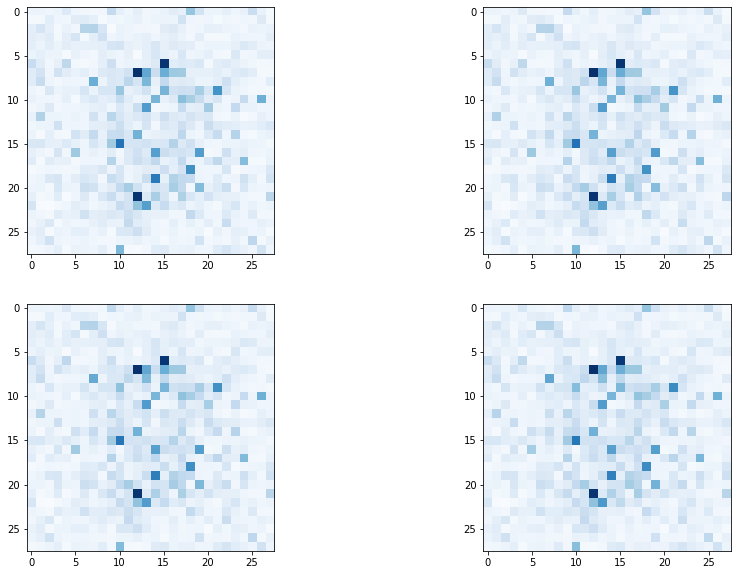

In [78]:
plt.figure(figsize = (15,10))
for i in range(4):
  plt.subplot(2,2,i+1)
  output = G.forward(generate_random(1))
  # 계산 그래프에 속해있어서 분리
  img =  output.detach().numpy().reshape(28,28)
  plt.imshow(img,interpolation=None,cmap = 'Blues')


In [ ]:
# 모드 붕괴 : 10개를 다양하게 생성 하지 못하고 한개의 모양으로만 생성, 또는 극히 일부만을 생성하는 현상 


In [91]:
# 손실함수를 BCELoss 로 변경하고 활성화 함수를 LeakyReLU()
# 신경망에서 나오는 값을 정규화
# 판별기
class Discriminator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(28*28,200),
        nn.LeakyReLU(),
        nn.LayerNorm(200),
        
        nn.Linear(200,1),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.BCELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.Adam(self.parameters(), lr= 1e-5)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)
    
  def train(self, inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    

  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )

In [92]:
# 생성기 : 훈련데이터의 여러 양상을 다양하게 반영하도록 이미지를 생성 
# 매훈련마다 임의의 상수를 입력(0.5는 안됨)
# 생성기
class Generator(nn.Module):
  # 초기화
  def __init__(self) -> None:
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.LeakyReLU(),
        nn.LayerNorm(200),

        nn.Linear(200,28*28),
        nn.Sigmoid()
    )
    # 손실함수 지정
    self.loss_function = nn.BCELoss()
    # 옵티마이져 - 스토캐스틱 경사하강법(확율적 경사하강법)
    self.optimizer = torch.optim.Adam(self.parameters(), lr= 1e-5)

    # 측정을 위한 변수
    self.count = 0;
    self.progress = [] 

  def forward(self,inputs):
    return self.model(inputs)

  def train(self, D,inputs, targets):
    # 신경망의 출력 계산(예측)
    outputs = self.forward(inputs)
    # 판별기로 전달
    outputs = D.forward(outputs)

    # 손실계산
    loss = self.loss_function(outputs,targets) 

    # 10회마다 오차를 저장
    self.count += 1;
    if self.count % 10 == 0:      
      self.progress.append(loss.detach().numpy() )
    
    # 기울기를 초기화하고 역전파후 가중치 갱신
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()      
  # 누적된 손실을 시각화
  def plot_progress(self):
    # progress = self.progress.detach().numpy()
    df = pd.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker = '.', yticks=(0,0.25,0.5),grid=True )    

In [108]:
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [111]:
# GAN  훈련
D = Discriminator()
G = Generator()

# 판별기 생성기 훈련
import torch
from tqdm import tqdm
for image, target in tqdm(train_dataset):    
  # 참에 대한 데이터
  image = image.view(1,28*28)     
  D.train(image,torch.FloatTensor([1.0]).reshape(1,1))  

  # 가짜 데이터에 대한 판별기 훈련  
  D.train(G.forward(generate_random_seed(1)).detach(), torch.FloatTensor([0.0])  ) 

  # 생성기
  G.train(D,generate_random(1), torch.FloatTensor([1.0]))

100%|██████████| 60000/60000 [07:46<00:00, 128.67it/s]


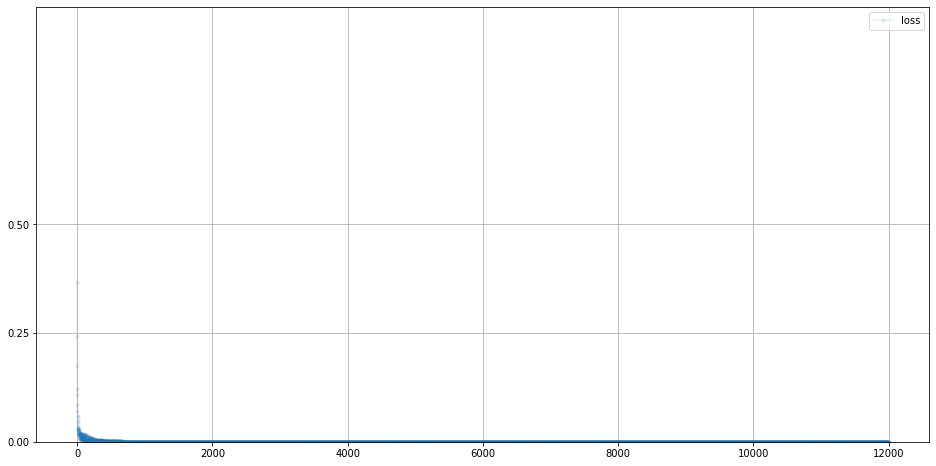

In [112]:
D.plot_progress()

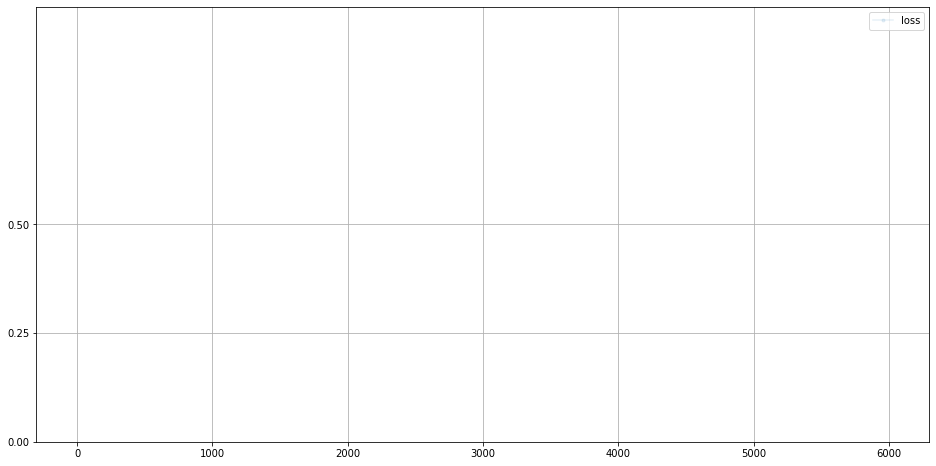

In [113]:
G.plot_progress()

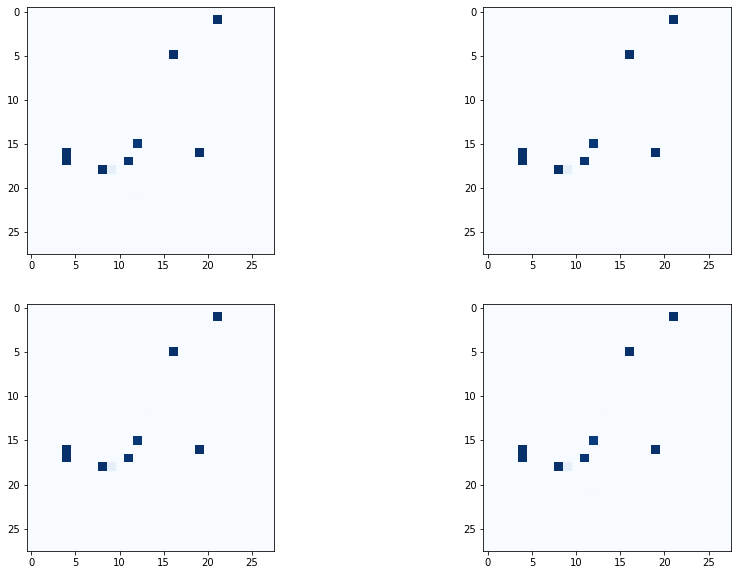

In [114]:
plt.figure(figsize = (15,10))
for i in range(4):
  plt.subplot(2,2,i+1)
  output = G.forward(generate_random(1))
  # 계산 그래프에 속해있어서 분리
  img =  output.detach().numpy().reshape(28,28)
  plt.imshow(img,interpolation=None,cmap = 'Blues')